<a href="https://colab.research.google.com/github/lsoica/blog/blob/main/assets/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN

RNNs are a type of neural network that are designed to process sequential data. Allows previous outputs to be used as inputs while having hidden states.

![RNN](../assets/images/rnn.png)

[RNN effectiveness](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)

RNNs allows us to process sequential data.

![RNN operates on sequences](../assets/images/rnn-operates-on-sequences.png)

## Let's build a RNN to classify names by origin

- We treat each name as a sequence of characters.
- Each character is represented by a one-hot vector. A tensor of fixed size where only one element is 1 and the rest are 0s. Each character is uniquely identified by its index.
- We have 57 characters in total in our vocabulary so the tensor size is 57.



## Install required packages

In [19]:
!pip install torch matplotlib



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Import libraries

In [2]:
import io
import os
import unicodedata
import string
import glob

import torch
import random

## Get the data

In [15]:
# https://download.pytorch.org/tutorial/data.zip
!rm -rf data.zip* data/
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!rm -rf data.zip*


--2024-12-03 13:00:09--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.14.23, 13.224.14.58, 13.224.14.44, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.14.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2,7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2,75M  2,41MB/s    in 1,1s    

2024-12-03 13:00:11 (2,41 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

## Some utility functions

In [24]:
# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories



"""
To represent a single letter, we use a “one-hot vector” of 
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

def category_from_output(output, all_categories):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [18]:
print(ALL_LETTERS)
print(N_LETTERS)
print(unicode_to_ascii('Ślusàrski'))

category_lines, all_categories = load_data()
print(category_lines['Italian'][:5])

print(letter_to_tensor('J')) # [1, 57]
print(line_to_tensor('Jones').size()) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Build the network

![RNN model architecture](../assets/images/rnn-model-architecture.png)

 - input and hidden states are concatenated
 - input to hidden is a linear layer. it's input size is input size + hidden size as the two are concatenated
 - input to output is a linear layer. it's input size is input size + hidden size as the two are concatenated
 - torch.cat is used to concatenate the input and hidden states. What id does is that it takes two tensors and concatenates them along a specified dimension. In this case, it concatenates the input and hidden states along dimension 1 (the second dimension).
 - softmax is applied to the output to get a probability distribution over the categories
 - optimizer is stochastic gradient descent: https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
 - criterion is negative log likelihood loss: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html



In [41]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 

class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
n_categories = len(all_categories)
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [42]:
print(category_lines[all_categories[0]][:5])
print(f"Number of categories: {n_categories}")
print(f"Number of letters: {N_LETTERS}")
print(f"Hidden size: {n_hidden}")

['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch']
Number of categories: 18
Number of letters: 57
Hidden size: 128


### Let's do one forward pass

In [43]:
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()
print(f"Input sequence size: {input_tensor.size()[0]}")
for i in range(input_tensor.size()[0]):
    output, hidden_tensor = rnn(input_tensor[i], hidden_tensor)
print(output.shape)
guess = category_from_output(output, all_categories)
print(guess)



Input sequence size: 6
torch.Size([1, 18])
Russian


## Train the network

5000 5.0 2.5811 Marik / Czech CORRECT
10000 10.0 2.2606 Strohkirch / Polish WRONG (German)
15000 15.0 3.3690 Salomon / Irish WRONG (Polish)
20000 20.0 1.8265 Araujo / Portuguese WRONG (Spanish)
25000 25.0 2.2065 Picasso / Italian WRONG (Spanish)
30000 30.0 0.4089 Ozawa / Japanese CORRECT
35000 35.0 2.0963 Kudrna / Japanese WRONG (Czech)
40000 40.0 0.5560 Domhnall / Irish CORRECT
45000 45.0 2.4638 Hubbard / Arabic WRONG (English)
50000 50.0 0.6749 Nozaki / Japanese CORRECT
55000 55.00000000000001 0.1868 Pispinis / Greek CORRECT
60000 60.0 4.9780 Park  / Polish WRONG (Korean)
65000 65.0 5.8802 Forer / Portuguese WRONG (Russian)
70000 70.0 1.0734 Meisner / German CORRECT
75000 75.0 0.9770 Freitas / Portuguese CORRECT
80000 80.0 4.1851 Gesse / Scottish WRONG (Russian)
85000 85.0 2.3861 Kurtz / German WRONG (Czech)
90000 90.0 0.3525 Malouf / Arabic CORRECT
95000 95.0 1.9145 Chung / Korean WRONG (Vietnamese)
100000 100.0 0.7894 Jung  / Korean CORRECT


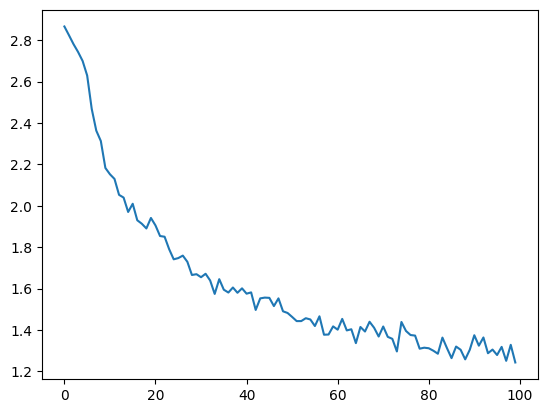

In [44]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output, all_categories)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")
        
    
plt.figure()
plt.plot(all_losses)
plt.show()

## Test the network

In [45]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output, all_categories)
        print(guess)


while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    
    predict(sentence)


> Albert
English

> Albert
English


## References
[PyTorch RNN Tutorial - Name Classification Using A Recurrent Neural Net](https://www.youtube.com/watch?v=WEV61GmmPrk)

## Let's build a RNN to classify images

This time we will use the PyTorch implementation of RNN.

In [46]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Hyper-parameters 
# input_size = 784 # 28x28
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

input_size = 28
sequence_length = 28
hidden_size = 128
num_layers = 2

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 7.15MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 226kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.44MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/2], Step [100/600], Loss: 1.0227
Epoch [1/2], Step [200/600], Loss: 0.6099
Epoch [1/2], Step [300/600], Loss: 0.3354
Epoch [1/2], Step [400/600], Loss: 0.5249
Epoch [1/2], Step [500/600], Loss: 0.5032
Epoch [1/2], Step [600/600], Loss: 0.2073
Epoch [2/2], Step [100/600], Loss: 0.3670
Epoch [2/2], Step [200/600], Loss: 0.2080
Epoch [2/2], Step [300/600], Loss: 0.3060
Epoch [2/2], Step [400/600], Loss: 0.2490
Epoch [2/2], Step [500/600], Loss: 0.1272
Epoch [2/2], Step [600/600], Loss: 0.2224
Accuracy of the network on the 10000 test images: 93.89 %


In [ ]:
### Now replace RNN with GRU

In [48]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Hyper-parameters 
# input_size = 784 # 28x28
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

input_size = 28
sequence_length = 28
hidden_size = 128
num_layers = 2

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.gru(x, h0)  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Epoch [1/2], Step [100/600], Loss: 0.7604
Epoch [1/2], Step [200/600], Loss: 0.2869
Epoch [1/2], Step [300/600], Loss: 0.1475
Epoch [1/2], Step [400/600], Loss: 0.4941
Epoch [1/2], Step [500/600], Loss: 0.1315
Epoch [1/2], Step [600/600], Loss: 0.1536
Epoch [2/2], Step [100/600], Loss: 0.0720
Epoch [2/2], Step [200/600], Loss: 0.1538
Epoch [2/2], Step [300/600], Loss: 0.2200
Epoch [2/2], Step [400/600], Loss: 0.0656
Epoch [2/2], Step [500/600], Loss: 0.0800
Epoch [2/2], Step [600/600], Loss: 0.0541
Accuracy of the network on the 10000 test images: 97.56 %


### Now replace GRU with LSTM


In [49]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Hyper-parameters 
# input_size = 784 # 28x28
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

input_size = 28
sequence_length = 28
hidden_size = 128
num_layers = 2

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.lstm(x, (h0,c0))  
        # or:
        #out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [N, 1, 28, 28]
        # resized: [N, 28, 28]
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Epoch [1/2], Step [100/600], Loss: 0.6295
Epoch [1/2], Step [200/600], Loss: 0.3988
Epoch [1/2], Step [300/600], Loss: 0.3129
Epoch [1/2], Step [400/600], Loss: 0.2452
Epoch [1/2], Step [500/600], Loss: 0.1903
Epoch [1/2], Step [600/600], Loss: 0.0380
Epoch [2/2], Step [100/600], Loss: 0.1356
Epoch [2/2], Step [200/600], Loss: 0.1113
Epoch [2/2], Step [300/600], Loss: 0.2232
Epoch [2/2], Step [400/600], Loss: 0.0467
Epoch [2/2], Step [500/600], Loss: 0.0519
Epoch [2/2], Step [600/600], Loss: 0.1000
Accuracy of the network on the 10000 test images: 97.64 %
